# Microbusiness density forecasting

American policy leaders strive to develop economies that are more inclusive and resilient to downturns. They're also aware that with advances in technology, entrepreneurship has never been more accessible than it is today. Whether to create a more appropriate work/life balance, to follow a passion, or due to loss of employment, studies have demonstrated that Americans increasingly choose to create businesses of their own to meet their financial goals. The challenge is that these "microbusinesses" are often too small or too new to show up in traditional economic data sources, making it nearly impossible for policymakers to study them. But data science could help fill in the gaps and provide insights into the factors associated these businesses.

In this project I will try to evaluate and compare several regression models that will predict those values using machine learning tools. It is based on kaggle competition - [GoDaddy - Microbusiness Density Forecasting](https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/overview).

<img src="img/img1.jpg" alt="Happy enterpreneur" title="Just look at this happy enterpreneur">


Let's begin with imports:

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import linear_model

## Data gathering
First, let's import data provided by the competition organizers that we will use. Datasets that will be imported:

- train_set - this contains information regarding each county and target variable for training:
    - row_id - An ID code for the row,
    - cfips - A unique identifier for each county using the Federal Information Processing System. The first two digits correspond to the state FIPS code, while the following 3 represent the county,
    - county_name - The written name of the county,
    - state_name - The name of the state,
    - first_day_of_month - The date of the first day of the month
    - microbusiness_density - Microbusinesses per 100 people over the age of 18 in the given county. This is the target variable. The population figures used to calculate the density are on a two-year lag due to the pace of update provided by the U.S. Census Bureau, which provides the underlying population data annually. 2021 density figures are calculated using 2019 population figures, etc.,
    - active - The raw count of microbusinesses in the county. Not provided for the test set.
- revealed_test - Set of revealed values for the most recent months available. I will use it to test my results.
- sample_submission - This set contains rows that must br predicted to take part in the competition.


In [33]:
train_set = pd.read_csv('data/train.csv')
train_set.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269


In [34]:
revealed_test = pd.read_csv('data/revealed_test.csv')
revealed_test.head(3)

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2022-11-01,1001,Autauga County,Alabama,2022-11-01,3.442677,1463
1,1001_2022-12-01,1001,Autauga County,Alabama,2022-12-01,3.470915,1475
2,1003_2022-11-01,1003,Baldwin County,Alabama,2022-11-01,8.257636,14145


In [32]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head(3)

,row_id,microbusiness_density
0,1001_2022-11-01,3.817671
1,1003_2022-11-01,3.817671
2,1005_2022-11-01,3.817671


# Building models

In [5]:
# Validation function
def smape(actual, forecast):
    numerator = np.abs(actual-forecast)
    denominator = (np.abs(actual) + np.abs(forecast))/2
    return 1/len(actual) * np.sum(numerator/denominator)

### Linear regression model - ordinary least squares

In [6]:
train_set.head()

,row_id,cfips,county,state,first_day_of_month,microbusiness_density,active
0,1001_2019-08-01,1001,Autauga County,Alabama,2019-08-01,3.007682,1249
1,1001_2019-09-01,1001,Autauga County,Alabama,2019-09-01,2.884870,1198
2,1001_2019-10-01,1001,Autauga County,Alabama,2019-10-01,3.055843,1269
3,1001_2019-11-01,1001,Autauga County,Alabama,2019-11-01,2.993233,1243
4,1001_2019-12-01,1001,Autauga County,Alabama,2019-12-01,2.993233,1243


### Basic linear regression - single row

SMAPE result: microbusiness_density    0.026439
dtype: float64


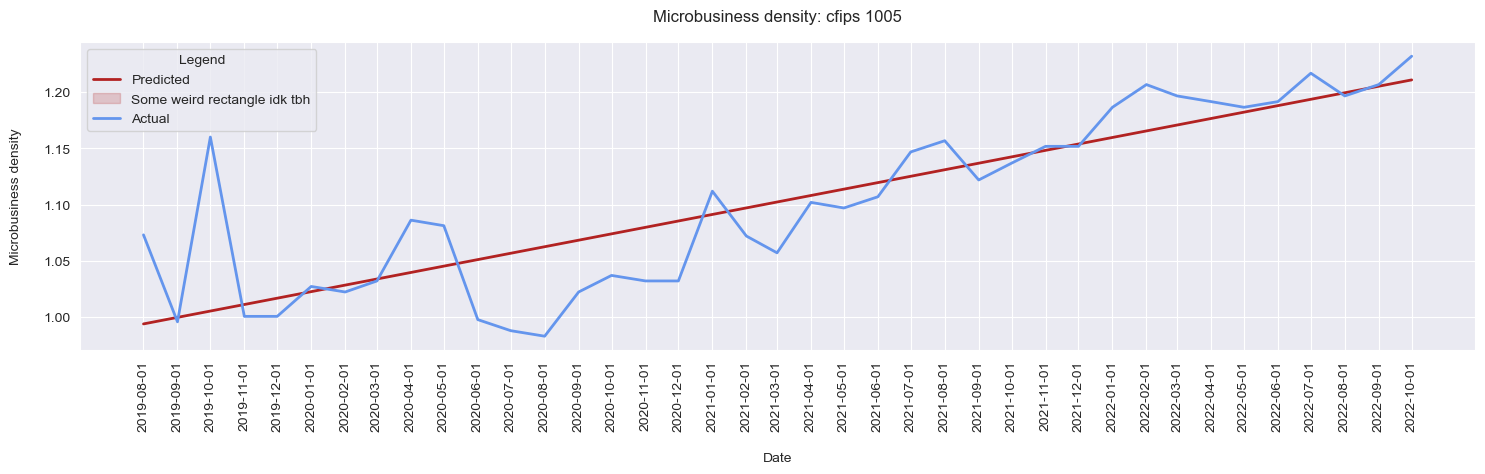

In [7]:
# Prepare data
cfips = 1005
lin_reg_df = train_set[train_set['cfips']==cfips][['first_day_of_month', 'microbusiness_density']]
lin_reg_df['time'] = [datetime.datetime.toordinal(x) for x in pd.to_datetime(lin_reg_df['first_day_of_month'])]
lin_reg_df['first_day_of_month'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in lin_reg_df['first_day_of_month']]
lin_reg_df.head()

# Training data
lin_reg_X_train = lin_reg_df.loc[:, ['time']]
lin_reg_y_train = lin_reg_df.loc[:, ['microbusiness_density']]
lin_reg_model = linear_model.LinearRegression()
lin_reg_model.fit(lin_reg_X_train, lin_reg_y_train)

# Predicting
y_pred = lin_reg_model.predict(lin_reg_X_train)

# Storing predicted values
y_pred_df = lin_reg_X_train
y_pred_df['predicted'] = y_pred
y_pred_df['first_day_of_month'] = [datetime.datetime.fromordinal(x) for x in y_pred_df['time']]
y_pred_df['microbusiness_density'] = lin_reg_df.loc[:, 'microbusiness_density']

# SMAPE
smape_result = smape(y_pred, lin_reg_y_train)
print(f'SMAPE result: {smape_result}')

# Create DF for plot
y_pred_plot_df = y_pred_df.melt(id_vars='first_day_of_month', value_vars=['predicted', 'microbusiness_density'])

# Plot
fig, ax = plt.subplots(figsize=(18, 4), squeeze=False)

ax = sns.lineplot(
    data=y_pred_plot_df,
    x='first_day_of_month',
    y='value',
    hue='variable',
    linewidth=2,
    palette=['firebrick', 'cornflowerblue']
)

ax.set_title(f'Microbusiness density: cfips {cfips}', pad=15)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Microbusiness density', labelpad=15)
ax.tick_params(axis='x', rotation=90)
ax.set_xticks(y_pred_df['first_day_of_month'])
plt.legend(title='Legend', labels=['Predicted', 'Some weird rectangle idk tbh', 'Actual'])

plt.show()

### Linear regression with lag feature - single row

In [8]:
# Prepare data
cfips = 1005
lin_reg_lag_df = train_set[train_set['cfips']==cfips][['first_day_of_month', 'microbusiness_density']]
lin_reg_lag_df['time'] = [datetime.datetime.toordinal(x) for x in pd.to_datetime(lin_reg_lag_df['first_day_of_month'])]
lin_reg_lag_df['first_day_of_month'] = [datetime.datetime.strptime(x, '%Y-%m-%d').date() for x in lin_reg_lag_df['first_day_of_month']]
lin_reg_lag_df['microbusiness_density_lag'] = lin_reg_lag_df['microbusiness_density'].shift(1)
lin_reg_lag_df = lin_reg_lag_df.dropna()
lin_reg_lag_df.head()

# Prepare linear regression on data
lin_reg_lag_X_train = lin_reg_lag_df.loc[:, ['microbusiness_density_lag']]
lin_reg_lag_y_train = lin_reg_lag_df.loc[:, ['microbusiness_density']]
lin_reg_lag_model = linear_model.LinearRegression()
lin_reg_lag_model.fit(lin_reg_lag_X_train, lin_reg_lag_y_train)

# Predict data
y_pred_lag = lin_reg_lag_model.predict(lin_reg_lag_X_train)

# SMAPE
smape_result = smape(y_pred_lag, lin_reg_lag_y_train)
print(f'SMAPE result: {smape_result}')

# Store predicted data
y_pred_lag_df = lin_reg_lag_X_train
y_pred_lag_df['predicted'] = y_pred_lag
y_pred_lag_df['first_day_of_month'] = lin_reg_lag_df['first_day_of_month']
y_pred_lag_df.head()

SMAPE result: microbusiness_density    0.028808
dtype: float64


,microbusiness_density_lag,predicted,first_day_of_month
79,1.073138,1.081738,2019-09-01
80,0.995794,1.017548,2019-10-01
81,1.160149,1.153951,2019-11-01
82,1.000628,1.021560,2019-12-01
83,1.000628,1.021560,2020-01-01


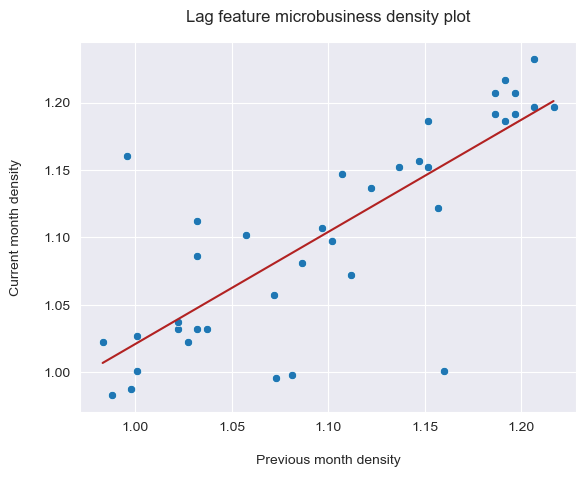

In [9]:
# Plot lag data
fig, ax = plt.subplots(squeeze=False)

sns.lineplot(
    data=y_pred_lag_df,
    x='microbusiness_density_lag',
    y='predicted',
    color='firebrick',
    ax=ax[0, 0]
)

sns.scatterplot(
    data=lin_reg_lag_df,
    x='microbusiness_density_lag',
    y='microbusiness_density',
    ax=ax[0, 0]
)
ax[0, 0].set_title('Lag feature microbusiness density plot', pad=15)
ax[0, 0].set_xlabel('Previous month density', labelpad=15)
ax[0, 0].set_ylabel('Current month density', labelpad=15)

plt.show()

**Conclusion:** From above we can see a strong relation between previous and current month data

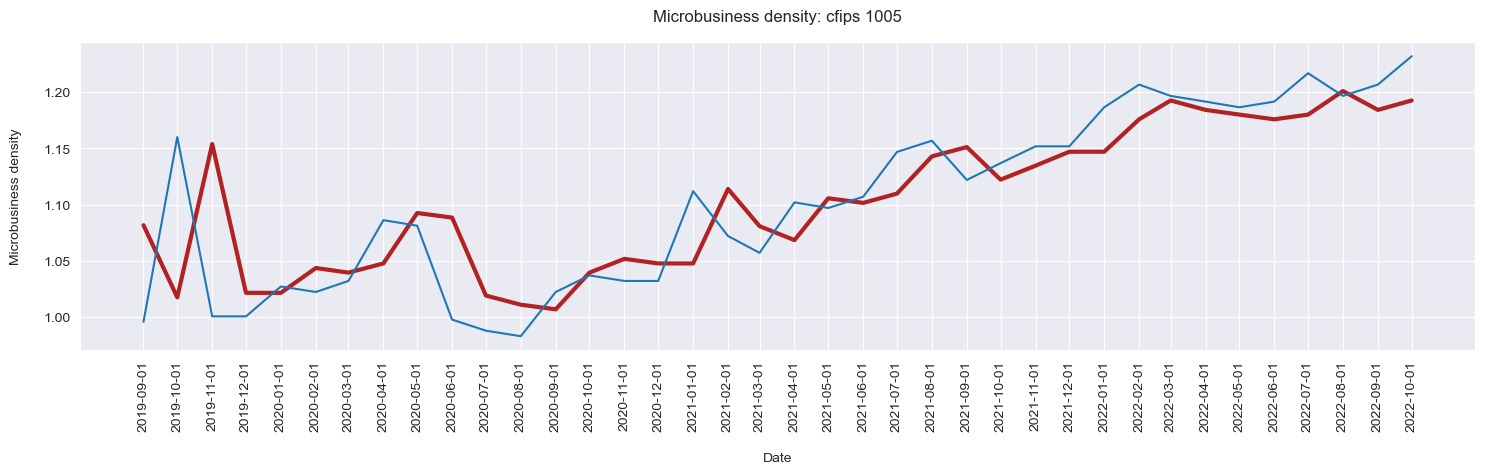

In [10]:
# Plot
fig, ax = plt.subplots(figsize=(18, 4), squeeze=False)

sns.lineplot(
    data=y_pred_lag_df,
    x='first_day_of_month',
    y='predicted',
    ax=ax[0, 0],
    color='firebrick',
    linewidth=3
)

sns.lineplot(
    data=lin_reg_lag_df,
    x='first_day_of_month',
    y='microbusiness_density',
    ax=ax[0, 0]
)
ax[0, 0].set_title(f'Microbusiness density: cfips {cfips}', pad=15)
ax[0, 0].set_xlabel('Date', labelpad=15)
ax[0, 0].set_ylabel('Microbusiness density', labelpad=15)
ax[0, 0].tick_params(axis='x', rotation=90)
ax[0, 0].set_xticks(y_pred_lag_df['first_day_of_month'])

plt.show()

**Conclusion:** even though the system looks more responsive to data changes, it gave worse SMAPE result.

## Linear regression with one parameter - prediction for 2022-12-01
Next I will try to predict microbusiness densities for all counties, for given day, and check the result

In [11]:
# Test data
test_day = '2022-12-01'
lin_reg_y_test = revealed_test.loc[revealed_test['first_day_of_month'] == test_day, ['cfips', 'microbusiness_density']]
lin_reg_y_test.head()

,cfips,microbusiness_density
1,1001,3.470915
3,1003,8.250630
5,1005,1.252272
7,1007,1.287240
9,1009,1.852060


In [12]:
# Turn off SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)

# Prepare data
lin_reg_multiple_df = train_set[['cfips', 'first_day_of_month', 'microbusiness_density']]
lin_reg_multiple_df['first_day_of_month'] = pd.to_datetime(lin_reg_multiple_df['first_day_of_month']) # Convert from str to datetime
lin_reg_multiple_df['first_day_of_month'] = [datetime.datetime.toordinal(x) for x in lin_reg_multiple_df['first_day_of_month']] # Convert to ordinal value

# Create DataFrame to store predicted values
test_day_ordinal = datetime.datetime.toordinal(datetime.datetime.strptime(test_day, '%Y-%m-%d'))
predict_df = pd.DataFrame([test_day_ordinal], columns=['first_day_of_month'])
forecast_df_columns = ['row_id', 'microbusiness_density']
forecast_df = pd.DataFrame(columns=forecast_df_columns)

# Create model
lin_reg_multiple_model = linear_model.LinearRegression()

for cfips in lin_reg_multiple_df['cfips'].unique():
    lin_reg_multiple_X_train = lin_reg_multiple_df.loc[lin_reg_multiple_df['cfips']==cfips, ['first_day_of_month']]
    lin_reg_multiple_y_train = lin_reg_multiple_df.loc[lin_reg_multiple_df['cfips']==cfips, ['microbusiness_density']]
    lin_reg_multiple_model.fit(lin_reg_multiple_X_train, lin_reg_multiple_y_train)
    predicted_value = lin_reg_multiple_model.predict(predict_df)
    # This could look like below, but we get nasty "valid feature names" warning
    # predicted_value = lin_reg_multiple_model.predict([[test_day_ordinal]])
    row_id = f'{cfips}_{test_day}'
    predicted_microbusiness_density = predicted_value[0][0]
    forecast_df_values = {
        forecast_df_columns[0]: row_id,
        forecast_df_columns[1]: predicted_microbusiness_density
    }
    forecast_df = pd.concat([forecast_df, pd.DataFrame(forecast_df_values, index=[0])])

forecast_df = forecast_df.reset_index(drop=True)

### SMAPE score for linear regression with one parameter

In [13]:
# Calculate SMAPE result
smape(forecast_df['microbusiness_density'], lin_reg_y_test['microbusiness_density'])

0.38845722849429876

## Linear regression with multiple parameters

We will try to modify our training sets by adding a couple of parameters.

In [14]:
# Test data
test_day = '2022-12-01'
lin_reg_y_test = revealed_test.loc[revealed_test['first_day_of_month'] == test_day, ['cfips', 'microbusiness_density']]

# Prepare data
lin_reg_multiparam_df = train_set[['cfips', 'state', 'first_day_of_month', 'microbusiness_density']]
lin_reg_multiparam_df['first_day_of_month_ordinal'] = pd.to_datetime(lin_reg_multiparam_df['first_day_of_month']) # Convert from str to datetime
lin_reg_multiparam_df['first_day_of_month_ordinal'] = [datetime.datetime.toordinal(x) for x in lin_reg_multiparam_df['first_day_of_month_ordinal']] # Convert to ordinal value

lin_reg_multiparam_df.head()

,cfips,state,first_day_of_month,microbusiness_density,first_day_of_month_ordinal
0,1001,Alabama,2019-08-01,3.007682,737272
1,1001,Alabama,2019-09-01,2.884870,737303
2,1001,Alabama,2019-10-01,3.055843,737333
3,1001,Alabama,2019-11-01,2.993233,737364
4,1001,Alabama,2019-12-01,2.993233,737394


In [15]:
# Create DF with additional data from csv files, containing several indicators for each state per month.
manufacturing_employment_data = pd.read_csv('data/all_indicators-all_data/manufacturing_employment_raw_in_thousands.csv')
private_employment_data = pd.read_csv('data/all_indicators-all_data/private_employment_raw_in_thousands.csv')
public_employment_data = pd.read_csv('data/all_indicators-all_data/public_employment_raw_in_thousands.csv')
retail_employment_data = pd.read_csv('data/all_indicators-all_data/retail_trade_employment_raw_in_thousands.csv')
total_employment_data = pd.read_csv('data/all_indicators-all_data/total_employment_raw_in_thousands.csv')
unemployment_rate_data = pd.read_csv('data/all_indicators-all_data/unemployment_rate_raw.csv')

# Sample head:
manufacturing_employment_data.head()

,Geography,1990-01-01,1990-02-01,1990-03-01,1990-04-01,1990-05-01,1990-06-01,1990-07-01,1990-08-01,1990-09-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
0,United States,17797.0,17893.0,17868.0,17845.0,17797.0,17776.0,17704.0,17649.0,17609.0,...,12689.0,12750.0,12769.0,12794.0,12831.0,12867.0,12884.0,12918.0,12926.0,12934.0
1,Alabama,365.5,362.5,360.6,366.6,366.2,367.5,364.6,364.7,364.9,...,266.6,267.9,268.3,268.8,268.4,268.3,270.6,271.7,272.1,272.7
2,Alaska,12.4,12.4,12.9,13.7,14.5,14.5,14.3,14.4,14.0,...,11.1,11.6,11.4,10.8,10.8,11.0,11.0,11.2,11.3,11.1
3,Arizona,177.3,177.6,177.1,176.5,176.7,176.8,177.2,176.8,176.1,...,186.1,189.5,189.3,190.8,193.1,194.7,196.9,197.6,197.6,198.4
4,Arkansas,218.4,218.9,217.8,219.0,219.2,219.9,219.8,220.2,221.1,...,162.2,162.7,162.9,163.2,164.4,164.9,165.1,165.0,164.2,164.4


I must reshape the dataframes to make it easier to merge

In [16]:
# Reshape datasets
manufacturing_employment_data_reshaped = manufacturing_employment_data.melt(id_vars=['Geography'], var_name='first_day_of_month',  value_name='manufacturing_employment')
private_employment_data_reshaped = private_employment_data.melt(id_vars=['Geography'], var_name='first_day_of_month',  value_name='private_employment')
public_employment_data_reshaped = public_employment_data.melt(id_vars=['Geography'], var_name='first_day_of_month',  value_name='public_employment')
retail_employment_data_reshaped = retail_employment_data.melt(id_vars=['Geography'], var_name='first_day_of_month',  value_name='retail_employment')
total_employment_data_reshaped = total_employment_data.melt(id_vars=['Geography'], var_name='first_day_of_month',  value_name='total_employment')
unemployment_rate_data_reshaped = unemployment_rate_data.melt(id_vars=['Geography'], var_name='first_day_of_month',  value_name='unemployment_rate')

In [17]:
# Before
unemployment_rate_data.head()

,Geography,1976-01-01,1976-02-01,1976-03-01,1976-04-01,1976-05-01,1976-06-01,1976-07-01,1976-08-01,1976-09-01,...,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01
0,United States,7.9,7.7,7.6,7.7,7.4,7.6,7.8,7.8,7.6,...,3.6,3.6,3.6,3.6,3.5,3.7,3.5,3.7,3.6,3.5
1,Alabama,6.6,6.6,6.6,6.5,6.4,6.5,6.6,6.7,6.8,...,2.9,2.8,2.7,2.6,2.6,2.6,2.6,2.7,2.7,2.8
2,Alaska,7.1,7.1,7.0,6.9,6.9,7.1,7.3,7.6,8.0,...,4.9,4.8,4.6,4.6,4.5,4.6,4.4,4.5,4.5,4.3
3,Arizona,10.2,10.2,10.1,10.0,9.8,9.7,9.7,9.6,9.6,...,3.3,3.2,3.2,3.3,3.3,3.5,3.7,3.9,4.1,4.0
4,Arkansas,7.3,7.3,7.3,7.2,7.1,6.9,6.8,6.7,6.6,...,3.1,3.2,3.2,3.2,3.3,3.4,3.5,3.6,3.7,3.6


In [18]:
# After
unemployment_rate_data_reshaped.head()

,Geography,first_day_of_month,unemployment_rate
0,United States,1976-01-01,7.9
1,Alabama,1976-01-01,6.6
2,Alaska,1976-01-01,7.1
3,Arizona,1976-01-01,10.2
4,Arkansas,1976-01-01,7.3


In [19]:
# Create gathered data DataFrame
gathered_data_df = pd.merge(
    manufacturing_employment_data_reshaped,
    private_employment_data_reshaped,
    how='left',
    left_on=['Geography', 'first_day_of_month'],
    right_on=['Geography', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    public_employment_data_reshaped,
    how='outer',
    left_on=['Geography', 'first_day_of_month'],
    right_on=['Geography', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    retail_employment_data_reshaped,
    how='outer',
    left_on=['Geography', 'first_day_of_month'],
    right_on=['Geography', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    total_employment_data_reshaped,
    how='outer',
    left_on=['Geography', 'first_day_of_month'],
    right_on=['Geography', 'first_day_of_month']
)

gathered_data_df = pd.merge(
    gathered_data_df,
    unemployment_rate_data_reshaped,
    how='outer',
    left_on=['Geography', 'first_day_of_month'],
    right_on=['Geography', 'first_day_of_month']
)

# Change column name just for convenience
gathered_data_df = gathered_data_df.rename(columns={'Geography': 'state'})

In [20]:
# Add First day of month ordinal value
gathered_data_df['first_day_of_month_ordinal'] = pd.to_datetime(gathered_data_df['first_day_of_month'])
gathered_data_df['first_day_of_month_ordinal'] = [datetime.datetime.toordinal(x) for x in gathered_data_df['first_day_of_month_ordinal']]

In [21]:
gathered_data_df.head()

,state,first_day_of_month,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate,first_day_of_month_ordinal
0,United States,1990-01-01,17797.0,91048.0,18151.0,13260.2,109199.0,5.4,726468
1,Alabama,1990-01-01,365.5,1310.5,325.4,191.2,1635.9,6.7,726468
2,Alaska,1990-01-01,12.4,162.0,68.8,25.3,230.8,7.2,726468
3,Arizona,1990-01-01,177.3,1207.3,266.1,195.6,1473.4,5.0,726468
4,Arkansas,1990-01-01,218.4,757.7,155.0,104.3,912.7,6.7,726468


In [22]:
# Select columns to join to avoid overlapping columns
merge_columns = ['cfips', 'state', 'first_day_of_month', 'microbusiness_density']

# Join DataFrames
lin_reg_allparams_df = pd.merge(
    lin_reg_multiparam_df.loc[:, merge_columns],
    gathered_data_df,
    how='left',
    left_on=['state', 'first_day_of_month'],
    right_on=['state', 'first_day_of_month']
)

lin_reg_allparams_df.head()

,cfips,state,first_day_of_month,microbusiness_density,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate,first_day_of_month_ordinal
0,1001,Alabama,2019-08-01,3.007682,268.7,1689.2,394.0,230.3,2083.2,2.9,737272
1,1001,Alabama,2019-09-01,2.884870,268.4,1688.7,394.0,230.5,2082.7,2.9,737303
2,1001,Alabama,2019-10-01,3.055843,268.8,1688.0,393.1,230.5,2081.1,3.0,737333
3,1001,Alabama,2019-11-01,2.993233,269.0,1690.3,393.2,230.5,2083.5,3.1,737364
4,1001,Alabama,2019-12-01,2.993233,269.3,1691.4,393.0,229.8,2084.4,3.2,737394


### Training and test data

In [23]:
# Select columns for training
X_columns = ['manufacturing_employment', 'private_employment', 'public_employment', 'retail_employment', 'total_employment', 'unemployment_rate', 'first_day_of_month_ordinal']
X_columns_cfips = X_columns + ['cfips']

# Select day to predict values
test_day = '2022-12-01'

# Prepare train and test data
# For train dataframes I will leave cfips column to make it easy to extract data for singular county
lin_reg_multiparam_X_train = lin_reg_allparams_df.loc[:, X_columns_cfips]
lin_reg_multiparam_y_train = lin_reg_allparams_df.loc[:, ['cfips', 'microbusiness_density']]
lin_reg_multiparam_X_test = gathered_data_df.loc[gathered_data_df['first_day_of_month']==test_day, X_columns]
lin_reg_multiparam_y_test = revealed_test.loc[revealed_test['first_day_of_month']==test_day, ['cfips', 'microbusiness_density']]

In [24]:
lin_reg_multiparam_X_train.head()

,manufacturing_employment,private_employment,public_employment,retail_employment,total_employment,unemployment_rate,first_day_of_month_ordinal,cfips
0,268.7,1689.2,394.0,230.3,2083.2,2.9,737272,1001
1,268.4,1688.7,394.0,230.5,2082.7,2.9,737303,1001
2,268.8,1688.0,393.1,230.5,2081.1,3.0,737333,1001
3,269.0,1690.3,393.2,230.5,2083.5,3.1,737364,1001
4,269.3,1691.4,393.0,229.8,2084.4,3.2,737394,1001


## Ridge regression

## Single county
First we will check how it operates for a single county

In [25]:
# Get data for just one county
cfips = 1005
ridge_single_X = lin_reg_multiparam_X_train.loc[lin_reg_multiparam_X_train['cfips']==cfips, X_columns]
ridge_single_y = lin_reg_multiparam_y_train.loc[lin_reg_multiparam_y_train['cfips']==cfips, 'microbusiness_density']

#Create model and predict
ridge_alphas = np.logspace(-5, 5, 11)
ridge_model = linear_model.RidgeCV(alphas=ridge_alphas)
ridge_model.fit(ridge_single_X, ridge_single_y)
ridge_single_forecast = ridge_model.predict(ridge_single_X)

# Store predicted data
ridge_single_forecast_df = pd.DataFrame(data=ridge_single_forecast, columns=['predicted'])
ridge_single_forecast_df['first_day_of_month'] = lin_reg_multiparam_df.loc[lin_reg_multiparam_df['cfips']==cfips, 'first_day_of_month'].values
ridge_single_forecast_df['microbusiness_density'] = lin_reg_multiparam_df.loc[lin_reg_multiparam_df['cfips']==cfips, 'microbusiness_density'].values
ridge_single_forecast_df.head()

,predicted,first_day_of_month,microbusiness_density
0,1.024547,2019-08-01,1.073138
1,1.033759,2019-09-01,0.995794
2,1.029192,2019-10-01,1.160149
3,1.038370,2019-11-01,1.000628
4,1.042568,2019-12-01,1.000628


In [26]:
# Calculate SMAPE
smape(ridge_single_forecast_df['microbusiness_density'], ridge_single_forecast_df['predicted'])

0.022727825439611382

We got better alignment than in ordinary least squares method.

In [27]:
# Transform the DataFrame to plot it
ridge_single_forecast_plot_df = ridge_single_forecast_df.melt(id_vars='first_day_of_month', var_name='status', value_name='density')
ridge_single_forecast_plot_df.head()

,first_day_of_month,status,density
0,2019-08-01,predicted,1.024547
1,2019-09-01,predicted,1.033759
2,2019-10-01,predicted,1.029192
3,2019-11-01,predicted,1.038370
4,2019-12-01,predicted,1.042568


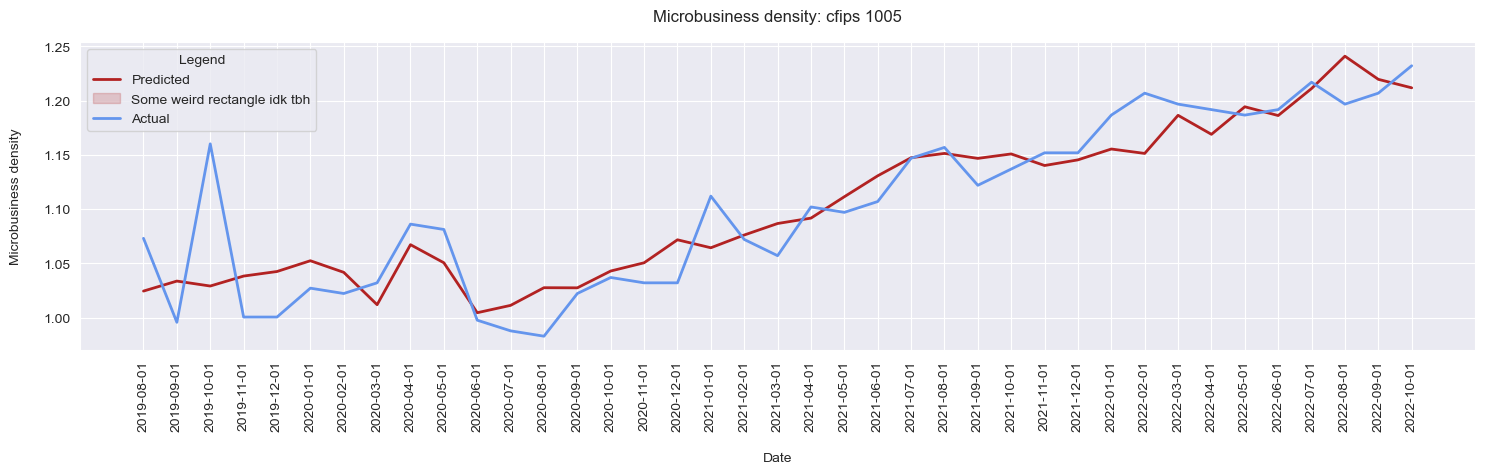

In [28]:
# Plot
fig, ax = plt.subplots(figsize=(18, 4))
ax = sns.lineplot(
    data=ridge_single_forecast_plot_df,
    x='first_day_of_month',
    y='density',
    hue='status',
    linewidth=2,
    palette=['firebrick', 'cornflowerblue']
)

ax.set_title(f'Microbusiness density: cfips {cfips}', pad=15)
ax.set_xlabel('Date', labelpad=15)
ax.set_ylabel('Microbusiness density', labelpad=15)
ax.tick_params(axis='x', rotation=90)
plt.legend(title='Legend', labels=['Predicted', 'Some weird rectangle idk tbh', 'Actual'])

plt.show()

## All counties
Let's check it for wider data

In [29]:
# Create DataFrame to store values
result_df_columns = ['cfips', 'first_day_of_month', 'microbusiness_density', 'predicted_density']
ridge_multiple_forecast_df = pd.DataFrame(columns=result_df_columns)

# Create model
ridge_alphas = np.logspace(-5, 5, 11)
ridge_model = linear_model.RidgeCV(alphas=ridge_alphas)

# Set test day
test_days = ['2022-11-01', '2022-12-01']

# Iterate over rows and predict following values
for cfips in lin_reg_allparams_df['cfips'].unique():
    # Train data
    ridge_multiple_X_train = lin_reg_multiparam_X_train.loc[lin_reg_multiparam_X_train['cfips']==cfips, X_columns]
    ridge_multiple_y_train = lin_reg_multiparam_y_train.loc[lin_reg_multiparam_y_train['cfips']==cfips, 'microbusiness_density']
    ridge_model.fit(ridge_multiple_X_train, ridge_multiple_y_train)
    # Predict using data for given state
    # Find state of this county
    state = lin_reg_multiparam_df.loc[lin_reg_multiparam_df['cfips']==cfips, 'state'].iat[0]
    # Get data and predict
    ridge_multiple_X_test = gathered_data_df.loc[(gathered_data_df['first_day_of_month'].isin(test_days)) & (gathered_data_df['state']==state), X_columns]
    ridge_multiple_y = ridge_model.predict(ridge_multiple_X_test)
    # Append results to the DataFrame
    for index, day in enumerate(test_days):
        results_list = [
            cfips, # cfips
            day, # first_day_of_month
            revealed_test.loc[(revealed_test['first_day_of_month']==day) & (revealed_test['cfips']==cfips), 'microbusiness_density'].iat[0], # microbusiness_density
            ridge_multiple_y[index] # predicted_density
        ]
        results_df = pd.DataFrame(data=[results_list], columns=result_df_columns)
        ridge_multiple_forecast_df = pd.concat([ridge_multiple_forecast_df, results_df])

In [30]:
# A quick sneak-peak into the results
ridge_multiple_forecast_df.head()

,cfips,first_day_of_month,microbusiness_density,predicted_density
0,1001,2022-11-01,3.442677,3.424219
0,1001,2022-12-01,3.470915,3.445445
0,1003,2022-11-01,8.257636,8.321419
0,1003,2022-12-01,8.250630,8.342122
0,1005,2022-11-01,1.247223,1.221841


### SMAPE for this test

In [31]:
smape(ridge_multiple_forecast_df['microbusiness_density'], ridge_multiple_forecast_df['predicted_density'])

0.05008509890199594

We got much better results than for ordinary least squares method (0.38 for just one test day)